<a href="https://colab.research.google.com/github/RogerHeederer/NLP_entry/blob/master/W2VwithSkipGram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수:', len(documents))

총 샘플 수: 11314


In [ ]:
news_df = pd.DataFrame({'document':documents})
news_df[:5]

,document
0,Well i'm not sure about the story nad it did s...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re..."
2,Although I realize that principle is not one o...
3,Notwithstanding all the legitimate fuss about ...
4,"Well, I will have to change the scoring on my ..."


In [ ]:
#특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")

In [ ]:
#길이가 3이하인 단어는 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [ ]:
news_df.isnull().values.any()

False

In [ ]:
# empty 값을 null로 변환한다
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [ ]:
news_df.dropna(inplace=True)
print('총 샘플 수: ', len(news_df))

총 샘플 수:  10995


In [ ]:
news_df[:10]

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased what disagre...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah expect people read actually accept hard a...
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...",well will have change scoring playoff pool unf...
5,"\n \nI read somewhere, I think in Morton Smit...",read somewhere think morton smith jesus magici...
6,\nOk. I have a record that shows a IIsi with ...,have record that shows iisi with without cache...
7,\n\n\nSounds like wishful guessing.\n\n\n\n\n'...,sounds like wishful guessing called what mean ...
8,Nobody is saying that you shouldn't be allowe...,nobody saying that shouldn allowed just force ...
9,\n I was wondering if anyone can shed any lig...,wondering anyone shed light just that these el...


In [ ]:
#불용어 제거
import nltk
nltk.download('stopwords')
  
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#단어가 1개 이하인 샘플의 인덱스를 찾고, 해당 샘플들을 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수:', len(tokenized_doc))

총 샘플 수: 10940


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k,v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
encoded[1]

[1026,
 532,
 2,
 60,
 98,
 582,
 107,
 800,
 23,
 79,
 4522,
 333,
 7838,
 864,
 421,
 3825,
 458,
 6488,
 458,
 2700,
 4730,
 333,
 23,
 9,
 4731,
 7262,
 186,
 310,
 146,
 170,
 642,
 1260,
 107,
 33568,
 13,
 985,
 33569,
 33570,
 9471,
 11491]

In [ ]:
vocab_size = len(word2idx) + 1
vocab_size

64277

##네거티브 샘플링을 통한 데이터셋 구성

In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [ ]:
skip_grams[0][0][0][0]

474

In [ ]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(statement (474), dvjrlojsq (62147)) -> 0
(israeli (442), disagree (1495)) -> 1
(world (70), sonically (61938)) -> 0
(described (984), existance (4865)) -> 1
(realize (1036), locutions (55846)) -> 0


In [ ]:
#윈도우 크기 내에서 중심 단어, 주변 단어의 페어를 가지는 경우 1의 레이블. 아닌 경우 0의 레이블
print('전체 샘플 수: ', len(skip_grams))

전체 샘플 수:  10


In [ ]:
print(len(pairs))
print(len(labels))

2220
2220


In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [ ]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(commited (7837), matyas (19000)) -> 0
(reason (149), rinkled (63053)) -> 0
(might (52), inhuman (10668)) -> 1
(rediculous (15227), media (702)) -> 1
(existance (4865), advertisements (10998)) -> 0
(europe (1095), fate (4359)) -> 0
(media (702), israels (13686)) -> 1
(story (603), suprising (20787)) -> 0
(clearly (661), foligno (10465)) -> 0
(blessing (10669), atrocities (4406)) -> 1


##Skip-Gram with Negative Sampling 직접 구현

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
embed_size = 100

In [ ]:
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

In [ ]:
word_embedding

<tf.Tensor 'embedding/embedding_lookup/Identity_1:0' shape=(None, 1, 100) dtype=float32>

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_2[0][0]                    
_______________________________________________________________________________________

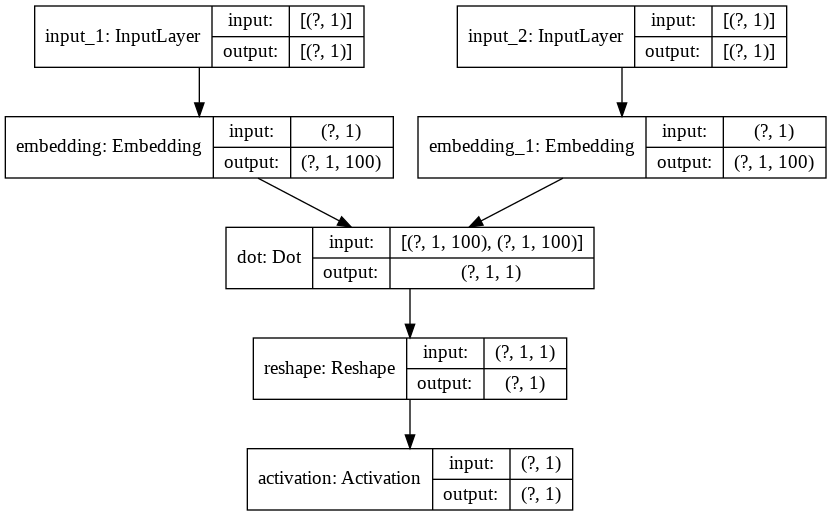

In [ ]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4627.7257277444005
